In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt
import pprint
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import reduce
from scipy import optimize,integrate

from plotutils import addtxt
mpl.style.use(['./scripts/theme_bw.mplstyle', './scripts/presentation.mplstyle'])
# http://jakevdp.github.io/blog/2015/08/07/frequentism-and-bayesianism-5-model-selection/

In [2]:
data = pd.DataFrame({"x":[ 0.42,  0.72,  0.  ,  0.3 ,  0.15,
                           0.09,  0.19,  0.35,  0.4 ,  0.54,
                           0.42,  0.69,  0.2 ,  0.88,  0.03,
                           0.67,  0.42,  0.56,  0.14,  0.2  ],
                     "y":[ 0.33,  0.41, -0.22,  0.01, -0.05,
                          -0.05, -0.12,  0.26,  0.29,  0.39, 
                           0.31,  0.42, -0.01,  0.58, -0.2 ,
                           0.52,  0.15,  0.32, -0.13, -0.09 ],
                     "dy":[ 0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                           0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                           0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                           0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1  ]})

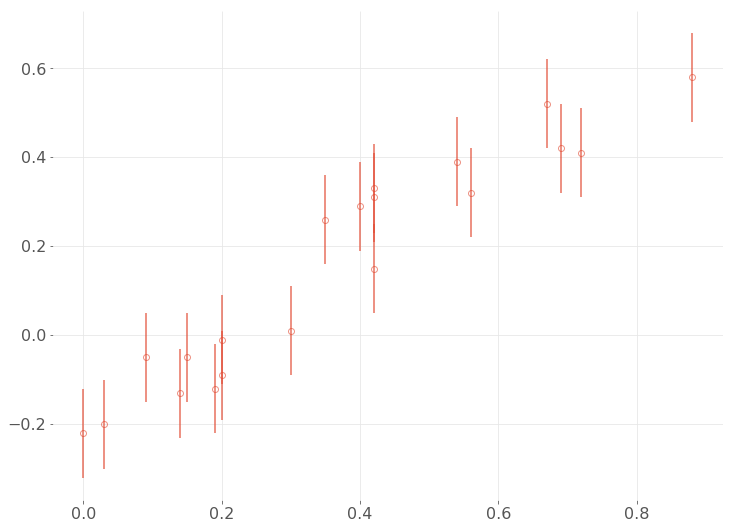

In [3]:
fig, ax = plt.subplots(figsize=(12,9))
ax.errorbar(data['x'], data['y'], yerr=data['dy'], ls='None', lw=2, marker='o', ms=6, mfc='None', alpha=0.6);

In [4]:
def polynomial_fit(theta, x):
    return sum(t * x**n for (n,t) in enumerate(theta)) # \sum_n \theta_n * x**n

def logL(*,theta, model, data):
    x,y,dy = data[:,0], data[:,1], data[:,2]
    y_fit  = model(theta, x)
    return sum(sp.stats.norm.logpdf(*args) for args in zip(y, y_fit, dy))

def best_theta(*, order, model, data):
    neg_logL   = lambda theta : -logL(theta=theta, model=model, data=data)
    init_theta = (order + 1) * [0]   # [\theta_0=0, \theta_1=0, .., \theta_n = 0]
    opt0       = optimize.minimize(neg_logL, init_theta, method='Nelder-Mead', options={'maxiter':2000, 'disp':0})
    opt1       = optimize.minimize(neg_logL, opt0['x'], method='L-BFGS-B', options={'maxiter':1000, 'disp':0})
    opt2       = optimize.minimize(neg_logL, opt1['x'], method='BFGS', options={'maxiter':500, 'disp':0})
    print(f"n = {order:3d}, logL = {-opt2['fun']:8.3e}, iter = {opt2['nit']:4d}, status = {opt2['message']}")
    return opt2

In [5]:
thetas  = [best_theta(order=n, model=polynomial_fit, data=data.to_numpy()) for n in range(1,10)]

n =   1, logL = 2.201e+01, iter =    2, status = Optimization terminated successfully.
n =   2, logL = 2.294e+01, iter =    5, status = Optimization terminated successfully.
n =   3, logL = 2.318e+01, iter =    4, status = Optimization terminated successfully.
n =   4, logL = 2.380e+01, iter =    3, status = Optimization terminated successfully.
n =   5, logL = 2.406e+01, iter =    7, status = Optimization terminated successfully.
n =   6, logL = 2.437e+01, iter =   42, status = Desired error not necessarily achieved due to precision loss.
n =   7, logL = 2.443e+01, iter =   65, status = Desired error not necessarily achieved due to precision loss.
n =   8, logL = 2.459e+01, iter =   70, status = Desired error not necessarily achieved due to precision loss.
n =   9, logL = 2.469e+01, iter =   60, status = Desired error not necessarily achieved due to precision loss.


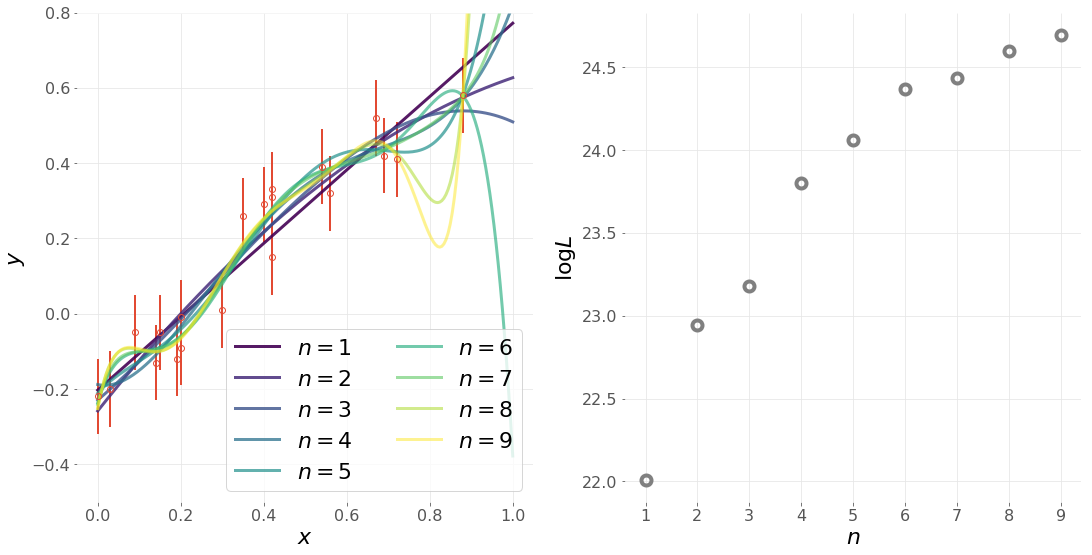

In [6]:
fig, [ax,bx] = plt.subplots(figsize=(18,9),ncols=2)

x = np.linspace(0, 1, num=200)
colors = mpl.cm.viridis(np.linspace(0,1,len(thetas)))
for n,theta in enumerate(thetas):
    ax.plot(x, polynomial_fit(theta['x'], x), label=f"$n={n+1}$", color=colors[n], alpha=0.9-0.05*n)
ax.errorbar(data['x'], data['y'], yerr=data['dy'], ls='None', lw=2, marker='o', ms=6, mfc='None', color='C0', label=None)
ax.set_ylim(-0.5, 0.8)
ax.legend(fontsize=(22),ncol=2,loc=4)

bx.plot(range(1,len(thetas)+1), [-theta['fun'] for theta in thetas], marker='o', color='gray', mfc='None', mew=4, ls='None')
for xx,l in zip([ax,bx], [r'$x$', r'$n$']):
    xx.set_xlabel(l, fontsize=22)
for xx,l in zip([ax,bx], [r'$y$', r'$\log L$']):
    xx.set_ylabel(l, fontsize=22)

Let's say we have to decide between two models, $n=1$ and $n=2$, for a linear and quadratic fit to the data.
How to decide between them?

\begin{align}
O_{21} &\equiv \frac{P(M_2 | D)}{P(M_1 | D)} \\
&= \frac{P(D | M_2)}{P(D|M_1)}\cdot \frac{P(M_2)}{P(M_1)} \\
&= \frac{Z_2}{Z_1} \cdot \frac{\Pi_2}{\Pi_1}
\end{align}
where $Z_i = P(D|M_i)$ is the evidence and $\Pi_i = P(M_i)$ the prior. The ratio of the likelihoods $Z_2/Z_1$ is also known as the 'Bayes Factor'.

We can compute the likelihood $P(D|M_i)$ by marginalizing over the model parameters $\theta$

\begin{align}
Z_i\equiv P(D | M_i) &= \int\mathrm{d}\theta\, P(D, \theta| M_i) \\
&= \int\mathrm{d}\theta\, P(D | \theta, M_i) \cdot P(\theta| M_i) \\
&= \int\mathrm{d}\theta\, L_i(\theta) \cdot P(\theta| M_i)
\end{align}
with $L_i(\theta) = P(D| \theta, M_i)$ the likelihood of the data given model $i$.

Evaluating this integral by brute force will only be possible for very simple models (low dimensions). However, following Jaynes (ch. 20), we can rewrite these factors into a more telling form


Let $L_i^\star = \max_{\theta}{L_i}$, the evidence is now
\begin{align}
Z_i &= L_i^\star\int\text{d}\theta\, \frac{L_i(\theta)}{L_i^\star} \cdot P(\theta|M_i)\\
&= L_i^\star W_i \\
\end{align}
where $W$ is the 'Ockham factor', which protects us from over-fitting. By definition, the prior $P(\theta | M_i)$ integrates to one, so we see that the factor of $L_i/L_i^\star$ is picking out the fraction of prior probability mass contained in the high-likelihood regions.

This allows us to write the Bayes factor appearing in the odds as
\begin{align}
O_{21} &= \frac{L_2^\star}{L_1^\star}\cdot\frac{W_2}{W_1}\cdot\frac{\Pi_2}{\Pi_1}
\end{align}

Revisit the discussion at the beginning of Ch.4 in Sivia and Skilling's book at this point.

Finally, note that the integrand in the evidence is closely related to the posterior $P(\theta| D, M_i)$ we calculated when considering model fitting (instead of model selection). Recall that

\begin{align}
P(\theta | D, M) &= \frac{L\cdot P(\theta | M)}{Z}
\end{align}

While MCMC allows us to compute $P(\theta | D, M)$, drawing samples following this distribution, it cannot be used to calculate the normalization factor $P(D | M)$ ! 

For this, other methods are required...

Anyway, let's do MCMC to see what the optimal parameters look like for each model.

In [7]:
xval  = data.x.to_numpy()
yval  = data.y.to_numpy()
dyval = data.dy.to_numpy()
with pm.Model() as linear_model: # y = a_1 x + a_0
    θ = pm.Uniform('θ', lower=-5.0, upper=5.0, shape=(2))
    y = pm.Normal('y', mu = θ[0] + θ[1]*xval, sd = dyval, observed = yval)
with pm.Model() as quadratic_model: # y = a x^2 + b x + c
    θ = pm.Uniform('θ', lower=-5.0, upper=5.0, shape=(3))
    y = pm.Normal('y', mu = θ[0] + θ[1]*xval + θ[2]*xval**2, sd = dyval, observed = yval)

In [8]:
with linear_model:
    trace1 = pm.sample(5000, tune = 20000, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ]
Sampling 2 chains: 100%|██████████| 50000/50000 [00:19<00:00, 2553.46draws/s]


In [9]:
with quadratic_model:
    trace2 = pm.sample(5000, tune=20000, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ]
Sampling 2 chains: 100%|██████████| 50000/50000 [00:46<00:00, 1066.99draws/s]
The acceptance probability does not match the target. It is 0.8860930061443913, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [10]:
labels = [f'$\\theta_{i}$' for i in range(len(thetas))]

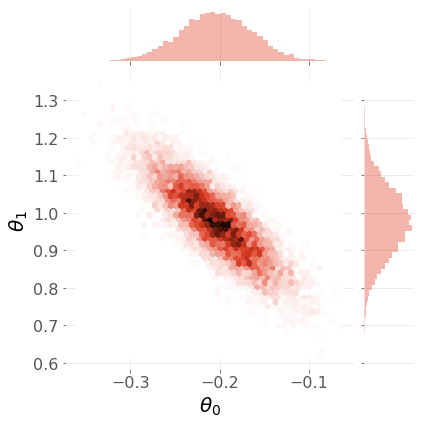

In [11]:
df1 = pd.DataFrame(trace1['θ'], columns=labels[:2])
jointplot = sns.jointplot(labels[0], labels[1], data=df1, kind='hex')

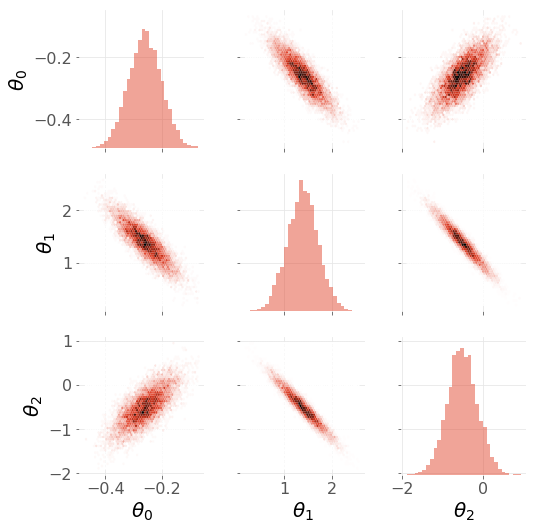

In [12]:
cmap = jointplot.ax_joint.collections[0].get_cmap()
df2 = pd.DataFrame(trace2['θ'], columns=labels[:3])
grid = sns.PairGrid(df2)
grid.map_diag(plt.hist, bins=30, alpha=0.5)
grid.map_offdiag(plt.hexbin, gridsize=50, linewidths=0, cmap=cmap)

Let's recall what exactly it is we need to calculate, the likelihood of the data $D$ for each of the models $M_i$

\begin{align}
P(D | M_i) 
&= \int\mathrm{d}\theta_i\, P(D | \theta_i, M_i) \cdot P(\theta_i | M_i) \\
&=\int\mathrm{d}\theta_i\, \frac{1}{\left(\theta_{\text{max}} - \theta_{\text{min}}\right)^{n_i}}\prod_i\frac{1}{\sqrt{2\pi\sigma_i^2}}\exp{\left[-\frac{\left(y_i - f_M(x_i)\right)^2}{2 \sigma_i^2}\right]} \\
&= \int\mathrm{d}\theta_i\, \exp{\bigg[-n_i\log{\left(\theta_{\text{max}} - \theta_{\text{min}}\right)} - \frac{1}{2}\sum_i\frac{\left(y_i - f(x_i)\right)^2}{\sigma_i^2} - \sum_i\frac{1}{2}\log{2\pi\sigma_i^2}\bigg]}
\end{align}

For what follows, we assume $\theta_\text{max} = -\theta_\text{min} = 5$
\begin{align}
P(\theta_i | M_i) &= \begin{cases}
10^{-n_i} & \textrm{if}\; |\theta_{i,j}| < 5 \; (\textrm{for all }j=1\ldots,n_i) \\
0 & \text{otherwise}
\end{cases}
\end{align}

In [14]:
theta_max = 5
def log_prior(theta):
    if np.any(np.abs(theta)) > theta_max:
        return -np.inf # log(0)
    else:
        # note the typo in jakevdp's blog
        return -len(theta)*np.log(2*theta_max)
    
def logL_slow(*,theta, model, data):
    x,y,dy = data[:,0], data[:,1], data[:,2]
    y_fit  = model(theta, x)
    return sum(sp.stats.norm.logpdf(*args) for args in zip(y, y_fit, dy))

def logL_fast(*, theta, model, data):
    x,y,dy = data[:,0], data[:,1], data[:,2]
    return -0.5*np.sum((yval - polynomial_fit(theta, xval))**2/dyval**2 + np.log(2.0*np.pi*dyval**2))

def log_posterior(theta, model, data):
    return log_prior(theta) + logL_fast(theta=theta, model=model, data=data)

def integrate_posterior1(log_posterior, xlim, ylim, model, data):
    func = lambda theta1, theta0: np.exp(log_posterior([theta0, theta1], model, data))
    return integrate.dblquad(func, xlim[0], xlim[1],
                             lambda x: ylim[0], lambda x: ylim[1])

def integrate_posterior2(log_posterior, xlim, ylim, zlim, model, data):
    func = lambda theta2, theta1, theta0: np.exp(log_posterior([theta0, theta1, theta2], model, data))
    return integrate.tplquad(func, xlim[0], xlim[1],
                             lambda x: ylim[0], lambda x: ylim[1],
                             lambda x, y: zlim[0], lambda x, y: zlim[1])

In [15]:
# Using the fast version...
xlim, ylim = zip(trace1[θ].min(axis=0), trace1[θ].max(axis=0))
%time Z1, err_Z1 = integrate_posterior1(log_posterior, xlim,  ylim, polynomial_fit, data.to_numpy())
print(f"Z1 = {Z1} +/- {err_Z1}")

xlim, ylim, zlim = zip(trace2[θ].min(axis=0), trace2[θ].max(axis=0))
%time Z2, err_Z2 = integrate_posterior2(log_posterior, xlim, ylim, zlim, polynomial_fit, data.to_numpy())
print(f"Z2 = {Z2} +/- {err_Z2}")

CPU times: user 254 ms, sys: 810 µs, total: 255 ms
Wall time: 255 ms
Z1 = 469313.66448661825 +/- 0.03156856158487087
CPU times: user 53.6 s, sys: 40.5 ms, total: 53.7 s
Wall time: 53.7 s
Z2 = 111052.8324932321 +/- 0.019049778582484578


\begin{align}
O_{21} &\equiv \frac{Z_2}{Z_1}\cdot\frac{\Pi_2}{\Pi_1} \\
&= \frac{L_2^\star}{L_1^\star}\cdot\frac{W_2}{W_1}\cdot\frac{\Pi_2}{\Pi_1} \\
e_{21} &\equiv 10 \log{\frac{L_2^\star}{L_1^\star}} + 10 \log{\frac{W_2}{W_1}} + 10\log{\frac{\Pi_2}{\Pi_1}}
\end{align}

In [22]:
L1,L2  = np.exp(-thetas[0]['fun']), np.exp(-thetas[1]['fun'])
W1,W2  = Z1/L1, Z2/L2
Lratio = L2/L1
Wratio = W2/W1
Odds   = Z2/Z1
print(f"Log(L)       = {np.log(L1):8.1e} , {np.log(L2):8.1e}")
print(f"Okham factor = {W1:8.1e} , {W2:8.1e}")
print(f"L2/L1        = {Lratio:8.3f}")
print(f"W2/W1        = {Wratio:8.3f}")
print(f"Bayes factor = {Odds:8.3f}")
print(f"Evidence     = {10*np.log10(Odds):4.0f}")
print(f"Evidence (L) = {10*np.log10(Lratio):4.0f}")
print(f"Evidence (W) = {10*np.log10(Wratio):4.0f}")

Log(L)       =  2.2e+01 ,  2.3e+01
Okham factor =  1.3e-04 ,  1.2e-05
L2/L1        =    2.536
W2/W1        =    0.093
Bayes factor =    0.237
Evidence     =   -6
Evidence (L) =    4
Evidence (W) =  -10


In [37]:
evidence = pd.DataFrame({'O':np.array([1, 2, 3, 4, 10, 20, 1e2, 1e3, 1e4, 1e5])})
evidence['10 log_10(O)'] = 10.0*np.log10(evidence['O'])
evidence['p'] = evidence['O']/(evidence['O'] + 1)
evidence.style.format({'p': "{:.5f}", '10 log_10(O)': "{:.1f}", 'O':"{0:.0f}:1"})

,O,10 log_10(O),p
0,1:1,0.0,0.50000
1,2:1,3.0,0.66667
2,3:1,4.8,0.75000
3,4:1,6.0,0.80000
4,10:1,10.0,0.90909
5,20:1,13.0,0.95238
6,100:1,20.0,0.99010
7,1000:1,30.0,0.99900
8,10000:1,40.0,0.99990
9,100000:1,50.0,0.99999


[Bayes Factors](http://links.jstor.org/sici?sici=0162-1459%28199506%2990%3A430%3C773%3ABF%3E2.0.CO%3B2-8)

Following Kass and Raftery, we have the following rule of thumb for how to interpret the evidence $10 \log_{10}(O)$
\begin{align}
0 \le O \le 5 & \qquad\textrm{Not worth more than a bare mention} \\
5 < O \le 10 & \qquad\textrm{Substantial} \\
10 < O \le 20 & \qquad\textrm{Strong} \\
20 < O &\qquad\textrm{Decisive}
\end{align}